In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import librosa
import librosa.display

import numpy as np
import os

import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings('always')

### Dataset

In [227]:
device = torch.device("cuda")

BATCH_SIZE = 128

In [3]:
def prepare_data(data_path='EEG_Data'):
    X = []
    Y = []
    
    for dir in os.listdir(data_path):
        folder_path = os.path.join(data_path, dir)
        dirs = os.listdir(folder_path)
        
        print(f'Number of samples in class {dir}: {len(dirs)}')
        
        xs = []
        ys = []
        
        for file in dirs:
            file_path = os.path.join(folder_path, file)
            spectrogram = np.load(file_path)
            xs.append(spectrogram)
            ys.append(int(dir))
        
        xs = np.array(xs)
        ys = np.array(ys)
        
        if len(xs) > 2400:
            random_indices = np.random.choice(len(xs), size=400, replace=False)
            xs = xs[random_indices]
            ys = ys[random_indices]
        
        X.extend(xs)
        Y.extend(ys)
    
    X = np.array(X)
    Y = np.array(Y)
    
    X = np.array([((x - x.mean()) / (x.std() + 1e-8)) for x in X])
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42, stratify=y_temp)
    
    print("\nClass distribution in training set:", Counter(y_train))
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = prepare_data()

Number of samples in class 0: 2906
Number of samples in class 1: 237
Number of samples in class 2: 1755
Number of samples in class 3: 497
Number of samples in class 4: 418

Class distribution in training set: Counter({2: 1228, 3: 348, 4: 292, 0: 280, 1: 166})


In [3]:
class SpectrogramPreprocessor:
    def __init__(self, normalize='standard', freq_range=None, 
                 noise_reduction=True, db_conversion=True):
        self.normalize = normalize
        self.freq_range = freq_range
        self.noise_reduction = noise_reduction
        self.db_conversion = db_conversion
        self.scaler = None
        
    def fit(self, spectrograms):
        if self.normalize:
            shape = spectrograms.shape
            if self.normalize == 'standard':
                self.scaler = StandardScaler()
            elif self.normalize == 'minmax':
                self.scaler = MinMaxScaler()
            self.scaler.fit(spectrograms.reshape(-1, 1))
    
    def transform(self, spectrograms):
        specs = spectrograms.copy()
        
        if self.db_conversion:
            specs = librosa.amplitude_to_db(specs, ref=np.max)
        
        if self.noise_reduction:
            noise_floor = np.mean(specs, axis=(1, 2), keepdims=True) - \
                         2 * np.std(specs, axis=(1, 2), keepdims=True)
            specs = np.maximum(specs, noise_floor)
        
        if self.freq_range is not None:
            specs = specs[:, self.freq_range[0]:self.freq_range[1], :]
        
        if self.scaler is not None:
            original_shape = specs.shape
            specs = self.scaler.transform(
                specs.reshape(-1, 1)
            ).reshape(original_shape)
        
        return specs

In [4]:
preprocessor = SpectrogramPreprocessor(
    normalize='standard',
    freq_range=(0, 60),
    noise_reduction=True,
    db_conversion=True
)

spec = X_train[3]
preprocessor.fit(X_train)
spec2 = preprocessor.transform(spec)
spec2.shape

plt.subplot(1, 2, 1)
plt.imshow(spec)
plt.subplot(1, 2, 2)
plt.imshow(spec2)

NameError: name 'X_train' is not defined

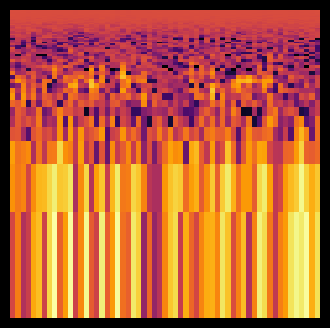

In [239]:
plt.figure(figsize=(4, 4))
plt.axis('off')
librosa.display.specshow(np.squeeze(spec2), y_axis='log', cmap='inferno');

In [7]:
class EEG_Dataset(Dataset):
    def __init__(self, X, Y, preprocessor=None):
        self.X = X
        self.Y = Y
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        
        if self.preprocessor is not None:
            x = self.preprocessor.transform(x)
            
            
        x = torch.FloatTensor(x)
        x = torch.permute(x, (2, 0, 1))
        y = torch.LongTensor(self.Y)
        y = y[idx]
        
        return x.to(device), y.to(device)

In [226]:
from PIL import Image
from torchvision import transforms

def prepare_image_data(data_path = 'EEG_Data_Processed2'):
    X = []
    Y = []
    
    transform = transforms.Compose([
        transforms.Resize((40, 80)),  
        transforms.ToTensor(),          
        # transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    for dir in os.listdir(data_path):
        folder_path = os.path.join(data_path, dir)
        dirs = os.listdir(folder_path)
        xs = []
        ys = []
        print(f'Number of samples in class {dir}: {len(dirs)}')
        for file in dirs:
            file_path = os.path.join(folder_path, file)
            
            image = Image.open(file_path).convert('L')
            
            # image = Image.open(file_path)
            # image = image.convert('RGB')
            image_tensor = transform(image)
            # X.append(image_tensor[:, -50:, :])
            xs.append(image_tensor)
            ys.append(int(dir))
            
        xs = torch.stack(xs)
        ys = np.array(ys)
        
        # if len(xs) > 700:
        #     random_indices = torch.randperm(len(xs))[:700]
        #     xs = xs[random_indices]
        #     ys = ys[random_indices]
        
        X.extend(xs)
        Y.extend(ys)
            
    return X, Y
        
X_processed, Y_processed = prepare_image_data()

Number of samples in class 0: 2907
Number of samples in class 1: 1185
Number of samples in class 2: 1755
Number of samples in class 3: 1491
Number of samples in class 4: 1254


In [194]:
# plt.imshow(torch.permute(X_processed[0], (1, 2, 0)).cpu().numpy())


In [228]:
X_train_processed, X_temp_processed, y_train_processed, y_temp_processed = train_test_split(X_processed, Y_processed, test_size=0.3, random_state=42, stratify=Y_processed)
X_val_processed, X_test_processed, y_val_processed, y_test_processed = train_test_split(X_temp_processed, y_temp_processed, test_size=0.6, random_state=42, stratify=y_temp_processed)
print( Counter(y_train_processed))
print(Counter(y_val_processed))
print(Counter(y_test_processed))

Counter({0: 2035, 2: 1228, 3: 1044, 4: 878, 1: 829})
Counter({0: 349, 2: 211, 3: 179, 4: 150, 1: 142})
Counter({0: 523, 2: 316, 3: 268, 4: 226, 1: 214})


In [229]:
class EEG_Dataset_Image(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
            
        y = torch.LongTensor(self.Y)
        y = y[idx]
        return x.to(device), y.to(device)

In [137]:
preprocessor = SpectrogramPreprocessor(
    normalize='standard',
    freq_range=(0, 60),
    noise_reduction=True,
    db_conversion=True
)
preprocessor.fit(X_train)

train_dataset = EEG_Dataset(X_train, y_train, preprocessor)
val_dataset = EEG_Dataset(X_val, y_val)
test_dataset = EEG_Dataset(X_test, y_test)

In [230]:
train_dataset_processed = EEG_Dataset_Image(X_train_processed, y_train_processed)
val_dataset_processed = EEG_Dataset_Image(X_val_processed, y_val_processed)
test_dataset_processed = EEG_Dataset_Image(X_test_processed, y_test_processed)

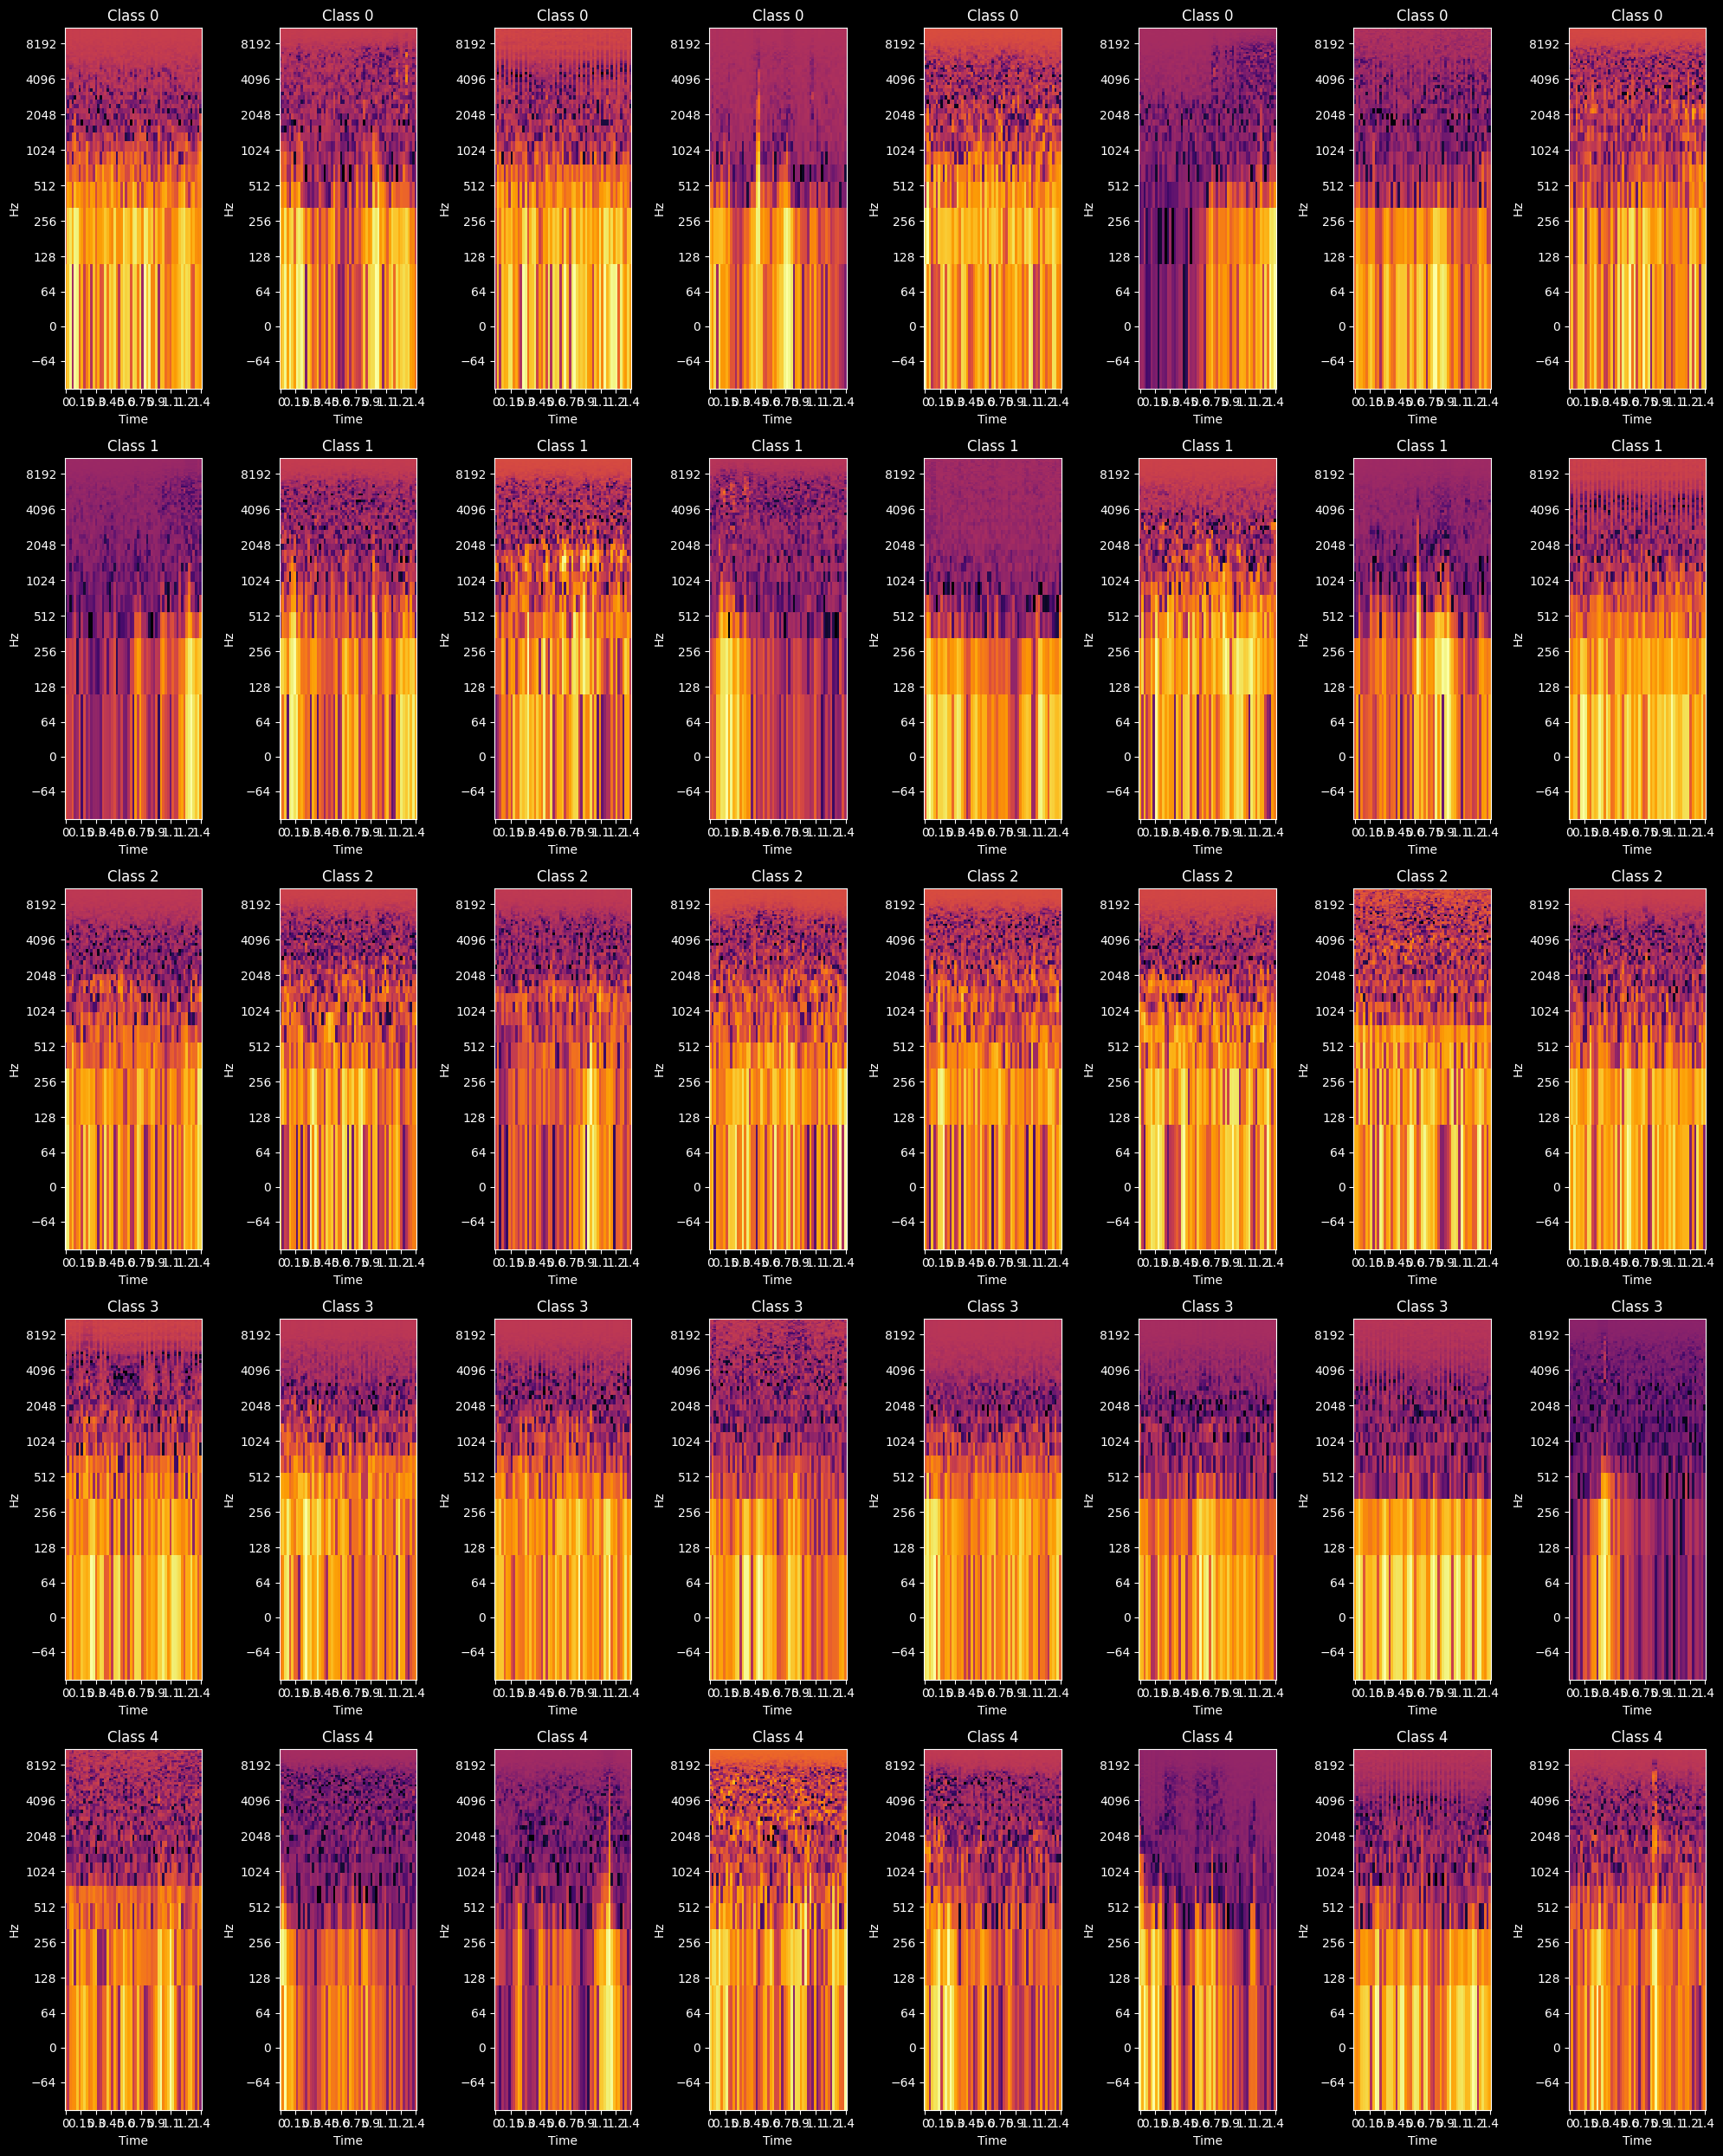

In [14]:
classes_to_show = [0, 1, 2, 3, 4] 
columns = 8  
rows = len(classes_to_show)

fig, axes = plt.subplots(rows, columns, figsize=(20, 5 * rows))

if rows == 1:
    axes = np.expand_dims(axes, axis=0)

j = 0
for row_idx, class_label in enumerate(classes_to_show):
    class_count = 0
    while class_count < columns:
        if train_dataset.__getitem__(j)[1] == class_label:
            x = np.squeeze(train_dataset.__getitem__(j)[0].detach().cpu().numpy())
            y = train_dataset.__getitem__(j)[1]
            ax = axes[row_idx][class_count]
            librosa.display.specshow(x, y_axis='log', x_axis='time', cmap='inferno', ax=ax)
            ax.set_title(f'Class {y}')
            class_count += 1
        j += 1  

plt.tight_layout()
plt.show()


In [158]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False)

In [231]:
train_loader_processed = DataLoader(train_dataset_processed, batch_size=BATCH_SIZE, shuffle=True)
val_loader_processed = DataLoader(val_dataset_processed, batch_size=BATCH_SIZE*2, shuffle=False)
test_loader_processed = DataLoader(test_dataset_processed, batch_size=BATCH_SIZE*2, shuffle=False)

## Model

In [17]:
class SpectrogramCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 512, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 512, kernel_size=1, padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 6 * 7, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 256)
        self.bn5 = nn.BatchNorm1d(256)
        
        self.fc_final = nn.Linear(256, 5) 
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 128 * 6 * 7) 
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn5(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc_final(x)
        return x

# model = SpectrogramCNN().to(device)
# xx1 = train_dataset[0][0].unsqueeze(0)
# xx2 = train_dataset[1][0].unsqueeze(0)
# xx = torch.cat((xx1, xx2), dim=0)
# yy = torch.cat((train_dataset[0][1].unsqueeze(0), train_dataset[1][1].unsqueeze(0)), dim=0)

# model(xx).shape

In [18]:
class SpectrogramLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3009, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 256)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.fc_final = nn.Linear(256, 5) 
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = x.squeeze(1)
        # print(x.shape)
        # x = torch.sum(x, dim=1)
        B, _, _ = x.shape
        x = x.view(B, -1)
        # print(x.shape)
        x = self.fc1(x)
        x =  self.bn1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc_final(x)
        
        return x

# model = SpectrogramLinear().to(device)
# xx1 = train_dataset[0][0].unsqueeze(0)
# xx2 = train_dataset[1][0].unsqueeze(0)
# xx = torch.cat((xx1, xx2), dim=0)
# yy = torch.cat((train_dataset[0][1].unsqueeze(0), train_dataset[1][1].unsqueeze(0)), dim=0)

# model(xx).shape

In [232]:
'''
class ProcessedSpectrogramCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 512, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(3, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(128 * 2 * 4, 2048)
        self.bn4 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 128)
        self.bn6 = nn.BatchNorm1d(128)
        
        self.fc_final = nn.Linear(128, 5) 
        
        self.dropout = nn.Dropout(0.53)
        
    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        # print(x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.pool2(x)
        
        # print(x.shape)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        # print(x.shape)
        x = x.reshape(-1, 128 * 2 * 4) 
        x = self.fc1(x)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn5(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = self.bn6(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        
        x = self.fc_final(x)
        return x
'''


class ProcessedSpectrogramCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 512, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 128, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(3, 3)
        
        self.fc1 = nn.Linear(128 * 4 * 8, 512)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.fc_final = nn.Linear(512, 5) 
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        # print(x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        # print(x.shape)
        x = x.reshape(-1, 128 * 4 * 8) 
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        
        x = self.dropout(x)
        
        x = self.fc_final(x)
        return x
# model = ProcessedSpectrogramCNN().to(device)
# xx1, yy1 = train_dataset_processed.__getitem__(0)
# xx2, yy2 = train_dataset_processed.__getitem__(1)
# xx = torch.cat((xx1.unsqueeze(0), xx2.unsqueeze(0)), dim=0)
# yy = torch.cat((yy1.unsqueeze(0), yy2.unsqueeze(0)), dim=0)

# model(xx).shape, xx.shape

In [245]:
# model = SpectrogramCNN().to(device)
# model = SpectrogramLinear().to(device)
model = ProcessedSpectrogramCNN().to(device)

In [246]:
from torch.optim.lr_scheduler import LambdaLR

step_size = 10
gamma = .1
lr = 1e-2
weight_decay = 1e-5
warmup_steps = 500
n_epochs = 200

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
total_steps = n_epochs * len(train_loader_processed)

scheduler = LambdaLR(optimizer, lambda step: min(lr, step / warmup_steps))

print('Y_train', Counter(y_train_processed))

Y_train Counter({0: 2035, 2: 1228, 3: 1044, 4: 878, 1: 829})


In [247]:
# class0 = 2034
# class1 = 498
# class2 = 1228
# class3 = 696
# class4 = 585


# total_samples = sum([class0, class1, class2, class3, class4])
# class_weights = torch.FloatTensor([
#     total_samples/(5 * class0),  
#     total_samples/(5 * class1),   
#     total_samples/(5 * class2),  
#     total_samples/(5 * class3),   
#     total_samples/(5 * class4)    
# ]).to(device)

# loss_fn = nn.CrossEntropyLoss(weight=class_weights)
loss_fn = nn.CrossEntropyLoss()

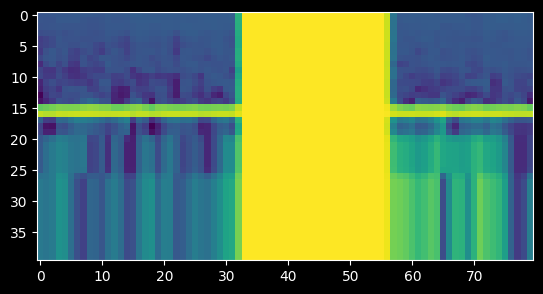

In [248]:
x = X_train_processed[100]
# x.shape
x = torch.permute(x, (1, 2, 0))
x.cpu().numpy().shape

plt.imshow(x.cpu().numpy());

In [ ]:
def train(train_loader, val_loader, n_epochs = 10):
    losses = []
    val_losses = []
    val_acc = []
    val_precision = []
    val_recall = []
    val_f1 = []
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)

            optimizer.zero_grad()
            loss = loss_fn(outputs, y_batch)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        scheduler.step()
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                outputs = model(x_batch)
                loss = loss_fn(outputs, y_batch)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

            precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
            recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=1)
            f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=1)

            losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss/len(val_loader))
            val_acc.append(100 * correct / total)
            val_precision.append(precision)
            val_recall.append(recall)
            val_f1.append(f1)

        if epoch % 5 == 0 or epoch + 1 == n_epochs:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print(f'Training Loss: {train_loss/len(train_loader):.4f}')
            print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
            print(f'Accuracy: {100 * correct / total:.4f}% Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
            
    return losses, val_losses, val_acc


losses, val_losses, val_acc = train(train_loader_processed, val_loader_processed, n_epochs)

Epoch 1/200
Training Loss: 1.7319
Validation Loss: 1.6208
Accuracy: 21.7265% Precision: 0.1564, Recall: 0.2173, F1 Score: 0.1355
Epoch 6/200
Training Loss: 1.2616
Validation Loss: 1.1821
Accuracy: 44.9079% Precision: 0.4115, Recall: 0.4491, F1 Score: 0.3604
Epoch 11/200
Training Loss: 1.1989
Validation Loss: 1.1484
Accuracy: 47.0417% Precision: 0.4395, Recall: 0.4704, F1 Score: 0.3993
Epoch 16/200
Training Loss: 1.1583
Validation Loss: 1.1357
Accuracy: 48.3996% Precision: 0.4518, Recall: 0.4840, F1 Score: 0.3970
Epoch 21/200
Training Loss: 1.1137
Validation Loss: 1.1445
Accuracy: 47.2357% Precision: 0.4740, Recall: 0.4724, F1 Score: 0.4431
Epoch 26/200
Training Loss: 1.0676
Validation Loss: 1.1221
Accuracy: 50.5335% Precision: 0.4859, Recall: 0.5053, F1 Score: 0.4440
Epoch 31/200
Training Loss: 1.0323
Validation Loss: 1.1214
Accuracy: 50.7274% Precision: 0.4956, Recall: 0.5073, F1 Score: 0.4616
Epoch 36/200
Training Loss: 0.9879
Validation Loss: 1.1076
Accuracy: 51.2124% Precision: 0.5

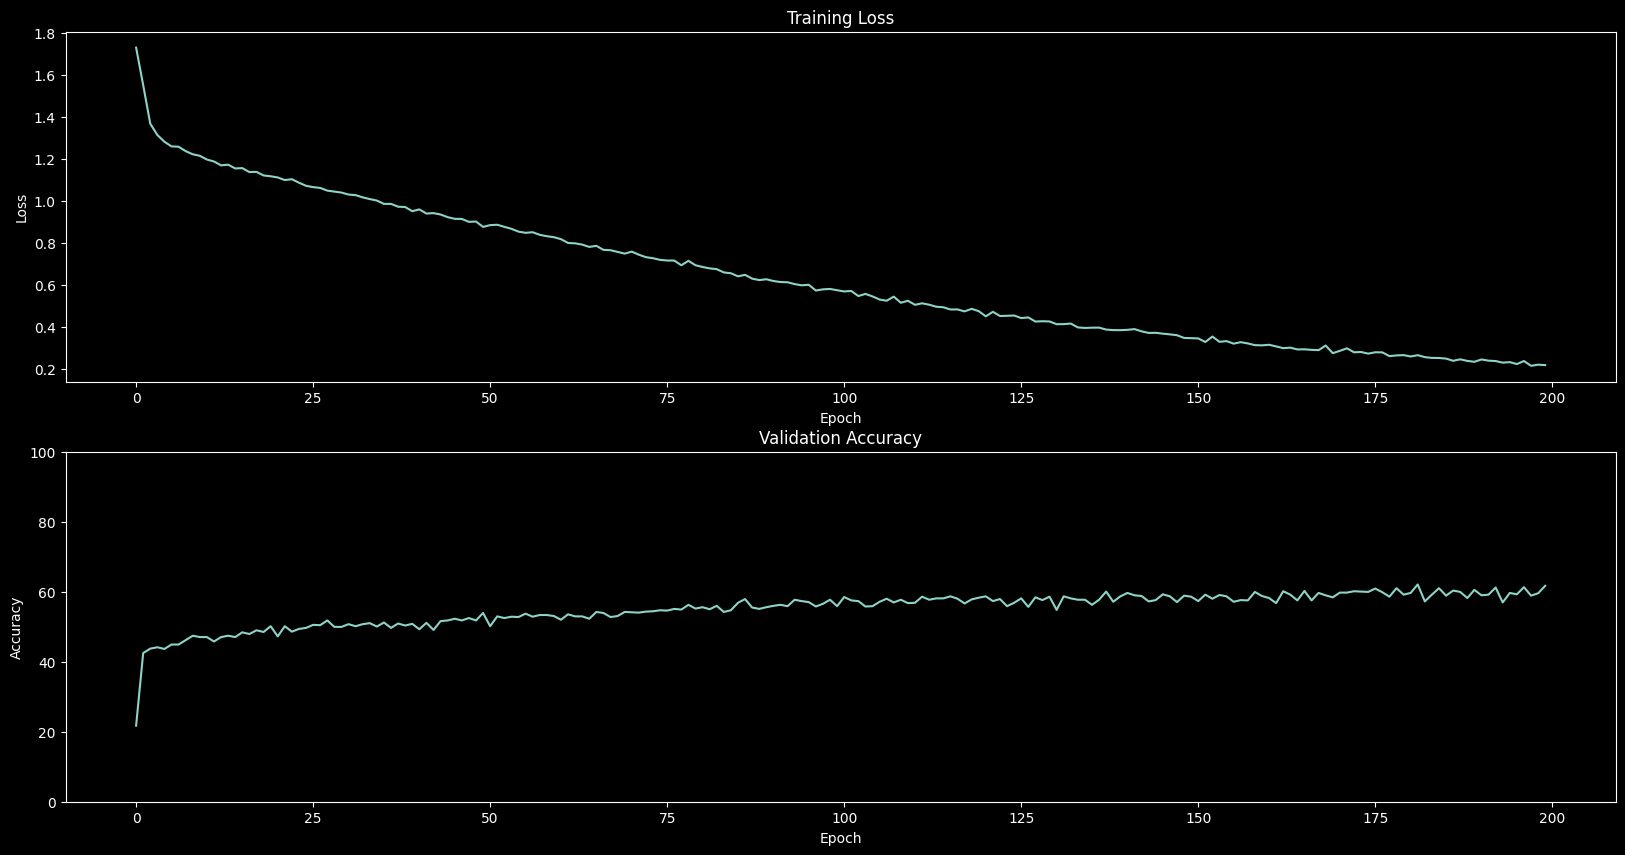

In [251]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(val_acc)
plt.ylim(0, 100)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [ ]:
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
        for x_batch, y_batch in test_loader_processed:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = loss_fn(outputs, y_batch)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        test_acc = (100 * correct / total)

print(f'Accuracy: {test_acc:.4f}%')

Accuracy: 61.0708%
